In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import pickle
import matplotlib

import sparseRRR

import warnings

from sklearn.linear_model import RidgeCV, ElasticNetCV

from plot_utils import adjust_spines

## Lasso regression analysis

#### Load data

In [2]:
M1_25degree = pickle.load(open("pickles/M1_features.pickle", "rb"))
ephys_features = np.array(M1_25degree["X_o"].columns)[:-4]
Xo = M1_25degree["X_o"].copy()
feature_list = range(23)

In [3]:
prop = pd.read_csv("../data/m1_patchseq_meta_data.csv", sep="\t")
prop = prop.rename(columns={"Targeted layer": "Layer"})
prop = prop[["Cell", "Layer", "Cre", "RNA type"]]
prop = prop.set_index("Cell")
prop = prop.reindex(Xo.index)
no_low_qual = np.array(list(map(str, prop["RNA type"].values))) != "nan"
prop = prop.loc[no_low_qual, :]
Xo = Xo.loc[no_low_qual, :]
celltypes = prop["RNA type"]

In [4]:
annotations = pd.read_csv("../data/cluster.annotation.csv", index_col=0)
cellTypeColors = {}
for celltype in np.unique(annotations["cluster_label"].values):
    cellTypeColors.update(
        {
            celltype: annotations.iloc[
                np.where(annotations["cluster_label"] == celltype)[0][0], :
            ]["cluster_color"]
        }
    )
colors = np.array([cellTypeColors[celltype] for celltype in celltypes])

In [5]:
model_param_names = np.array(
    [
        "C",
        r"$R_{input}$",
        r"$\tau$",
        r"$g_{Nat}$",
        r"$g_{Na}$",
        r"$g_{Kd}$",
        r"$g_{M}$",
        r"$g_{Kv31}$",
        r"$g_{L}$",
        r"$E_{leak}$",
        r"$\tau_{max}$",
        "VT",
        r"$r_{SS}$",
    ]
)
prior_min = [0.1, 20, 0.1, 0, 0, 0, 0, 0, 0, -130, 50, -90, 0.1]
prior_max = [15, 1000, 70, 250, 100, 30, 3, 250, 3, -50, 4000, -35, 3]

In [6]:
fav_tr_schedule = "2d"

In [7]:
with open(
    "../code/save_model_parameters/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((len(model_param_names),)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

In [8]:
data_exons = pd.read_csv(
    "../data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
IonChannelGenes = pd.read_csv(
    "../data/GO_term_summary_20211104_075621.txt", header=0, sep="\t"
)
selectedGenes = np.array(
    [
        (gene in IonChannelGenes["MGI Gene/Marker ID"].values)
        | (
            gene
            in [
                "Pvalb",
                "Lamp5",
                "Vip",
                "Sst",
            ]
        )
        for gene in data_exons.index
    ]
)
enough_counts = np.sum(data_exons, axis=1) >= 10
data_exons = data_exons.loc[selectedGenes & enough_counts, :]
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names[selectedGenes & enough_counts]

In [9]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

In [10]:
highest_posterior_samples_standardized = (
    highest_posterior_samples - highest_posterior_samples.mean(axis=0)
) / highest_posterior_samples.std(axis=0)
M = highest_posterior_samples_standardized.astype("float64")

In [11]:
M.shape

(955, 13)

In [12]:
G.shape

(955, 427)

#### Per feature ridge regression analysis with permutation analysis.

In [14]:
r2_ridge = np.zeros((M.shape[1],))

n_reps=100
r2_ridge_shuffle = np.zeros((M.shape[1],n_reps))
regr = RidgeCV(alphas=np.geomspace(.0001, 10000, 50), store_cv_values=True)

print('# cells with defined (non-nan) value per feature:')

for f in range(M.shape[1]):
    M_=M[:,f][:,np.newaxis].copy()
    regr.fit(G, M_)

    r2_ridge[f] = 1 - np.min(np.mean(regr.cv_values_, axis=0)) # take the alpha with mimimal mean MSE over cv
    
    for rep in range(n_reps):
        regr.fit(G, M_[np.random.permutation(M.shape[0]),:])
        r2_ridge_shuffle[f, rep] = 1 - np.min(np.mean(regr.cv_values_, axis=0))

# cells with defined (non-nan) value per feature:
C  :  955
$R_{input}$  :  955
$\tau$  :  955
$g_{Nat}$  :  955
$g_{Na}$  :  955
$g_{Kd}$  :  955
$g_{M}$  :  955
$g_{Kv31}$  :  955
$g_{L}$  :  955
$E_{leak}$  :  955
$\tau_{max}$  :  955
VT  :  955
$r_{SS}$  :  955


#### Per feature elastic net regression analysis.

In [20]:
r2_elasticnet = np.zeros((M.shape[1],))
regr = ElasticNetCV(alphas=np.geomspace(.0001, 10000, 50), l1_ratio=1.)

for f in range(M.shape[1]):
    print('.', end='')

    M_=M[:,f][:,np.newaxis].copy()
    
    regr.fit(G, M_.ravel())

    r2_elasticnet[f] = 1 - np.min(np.mean(regr.mse_path_, axis=1)) # take the alpha with mimimal mean MSE over cv

.............

In [25]:
r2_elasticnet

array([0.26631313, 0.10312578, 0.10794215, 0.14239916, 0.02713377,
       0.37909877, 0.01929699, 0.30899363, 0.12318916, 0.02381543,
       0.0652131 , 0.15759591, 0.59447483])

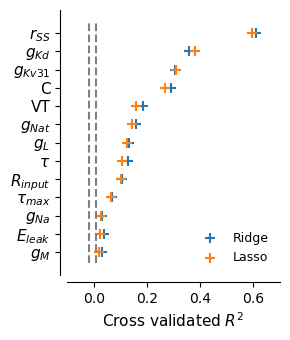

In [40]:
order=np.argsort(r2_elasticnet)

fig, ax = plt.subplots(1,1,figsize=(3,3.5))
#alphas = np.array([.25, .5, .75, 1])
ax.scatter(r2_ridge[order],
           np.linspace(1,M.shape[1],M.shape[1]),
            s=60, marker= '+', label='Ridge')
ax.scatter(r2_elasticnet[order],
           np.linspace(1,M.shape[1],M.shape[1]),
            s=60, marker='+', label='Lasso')
# for rep in range(nreps):
#     ax.scatter(r2_ridge_shuffle[:,rep],
#                 np.linspace(1.2,Y_.shape[1]+.2,Y_.shape[1]),
#                 s=10, marker= '+', c='red')
ylim_1=ax.get_ylim()[0]
ylim_2=ax.get_ylim()[1]
ax.vlines(np.percentile(r2_ridge_shuffle, 1), ylim_1, ylim_2, color='grey', linestyle='dashed')
ax.vlines(np.percentile(r2_ridge_shuffle, 99), ylim_1, ylim_2, color='grey', linestyle='dashed')

ax.set_xlim(xmin=-0.1,xmax=0.7)
adjust_spines(ax, spines=['bottom', 'left'])
ax.set_yticks(np.linspace(1,M.shape[1],M.shape[1]))
ax.set_yticklabels(model_param_names[order], fontsize=11)
ax.legend(loc='lower right', fontsize=9, frameon=False)
ax.set_xlabel(r'Cross validated $R^2$', fontsize=11)
sns.despine()
plt.tight_layout()
plt.savefig('../figures/figure_x2.png', bbox_inches="tight", pad_inches=0)

In [30]:
for i in range(M.shape[1]):
        print('P value for : ' + model_param_names[i] + ':', sum(r2_ridge_shuffle[i,:]>r2_ridge[i])/100)

P value for : C: 0.0
P value for : $R_{input}$: 0.0
P value for : $\tau$: 0.0
P value for : $g_{Nat}$: 0.0
P value for : $g_{Na}$: 0.0
P value for : $g_{Kd}$: 0.0
P value for : $g_{M}$: 0.0
P value for : $g_{Kv31}$: 0.0
P value for : $g_{L}$: 0.0
P value for : $E_{leak}$: 0.0
P value for : $\tau_{max}$: 0.0
P value for : VT: 0.0
P value for : $r_{SS}$: 0.0


To predict $r_{SS}$, which genes does pure lasso regression select?

In [45]:
ind=np.where(model_param_names=='$r_{SS}$')[0][0]
print('25 most important genes to predict ' + model_param_names[ind])
regr = ElasticNetCV(l1_ratio=1.)
regr.fit(G, M[:,ind])
gene_names[np.argsort(np.abs(regr.coef_))[-25:]] # 25 most important genes

25 most important genes to predict $r_{SS}$


array(['Kcnb2', 'Ryr1', 'Kcnq5', 'Cacna2d4', 'Chrna4', 'Cacna2d2',
       'Trpc5', 'Hcn1', 'Kcnab3', 'Scn1b', 'Kcnc3', 'Grik1', 'Cacng3',
       'Apol7a', 'Pvalb', 'Lamp5', 'Pex5l', 'Kcnip3', 'Kcnip4', 'Gabra5',
       'Slc24a4', 'Kcnip1', 'Cacna2d1', 'Kcnv1', 'Slc17a7'], dtype=object)

In [46]:
gene_names[regr.coef_!=0] # all nonzero genes

array(['Ano3', 'Ano4', 'Apol7a', 'Cacna1f', 'Cacna1g', 'Cacna2d1',
       'Cacna2d2', 'Cacna2d3', 'Cacna2d4', 'Cacng3', 'Cacng7', 'Chrna4',
       'Clca3a1', 'Clca3a2', 'Clca4b', 'Gabra5', 'Glra2', 'Grik1',
       'Grik2', 'Grin2d', 'Grm7', 'Hcn1', 'Htr1b', 'Kcna4', 'Kcnab3',
       'Kcnb2', 'Kcnc3', 'Kcnip1', 'Kcnip3', 'Kcnip4', 'Kcnk7', 'Kcnk9',
       'Kcnmb2', 'Kcnmb4', 'Kcnq5', 'Kcnt2', 'Kcnv1', 'Lamp5', 'Marcksl1',
       'Mcub', 'Pex5l', 'Piezo2', 'Pkd1l1', 'Pkd1l2', 'Pvalb', 'Rasa3',
       'Ryr1', 'Scn1a', 'Scn1b', 'Slc17a7', 'Slc24a4', 'Snap25', 'Tmc6',
       'Trpc5', 'Trpv2', 'Trpv6'], dtype=object)

To predict $g_{Kv3.1}$, which genes does pure lasso regression select?

In [47]:
model_param_names

array(['C', '$R_{input}$', '$\\tau$', '$g_{Nat}$', '$g_{Na}$', '$g_{Kd}$',
       '$g_{M}$', '$g_{Kv31}$', '$g_{L}$', '$E_{leak}$', '$\\tau_{max}$',
       'VT', '$r_{SS}$'], dtype='<U12')

In [48]:
ind=np.where(model_param_names=='$g_{Kv31}$')[0][0]
print('25 most important genes to predict ' + model_param_names[ind])
regr = ElasticNetCV(l1_ratio=1.)
regr.fit(G, M[:,ind])
gene_names[np.argsort(np.abs(regr.coef_))[-25:]] # 25 most important genes

25 most important genes to predict $g_{Kv31}$


array(['Kcnk3', 'Apol8', 'Gabrb1', 'Kcnh1', 'Gabrd', 'Hcn1', 'Lrrc8b',
       'Nmur2', 'Scn1a', 'Hcn2', 'Slc24a2', 'Trpm6', 'Vip', 'Cnr1',
       'Kcnc2', 'Kcnab3', 'Vdac2', 'Lrrc38', 'Cacna2d2', 'Scn1b', 'Kcnc1',
       'Scn3b', 'Pvalb', 'Cacna2d1', 'Slc17a7'], dtype=object)

In [49]:
gene_names[regr.coef_!=0] # all nonzero genes

array(['Ano4', 'Apol8', 'Asic4', 'Atp5d', 'Best1', 'Cacna2d1', 'Cacna2d2',
       'Ccdc51', 'Cnr1', 'Fxyd4', 'Gabrb1', 'Gabrd', 'Glra2', 'Hcn1',
       'Hcn2', 'Kcna3', 'Kcnab2', 'Kcnab3', 'Kcnc1', 'Kcnc2', 'Kcnh1',
       'Kcnj5', 'Kcnk12', 'Kcnk3', 'Kcnk9', 'Lamp5', 'Lrrc38', 'Lrrc8b',
       'Nmur2', 'Otop1', 'Pkd2', 'Pvalb', 'Scn1a', 'Scn1b', 'Scn3b',
       'Slc17a7', 'Slc1a1', 'Slc24a2', 'Slc24a3', 'Slc26a6', 'Trpm6',
       'Vdac2', 'Vip'], dtype=object)